In [1]:
import numpy as np
import glob, urllib

from scipy import integrate

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm.notebook import tqdm

import decimal as dc
from multiprocessing import Pool

### Setting constants and parameters

For the presented simulations and most of the analyses, LAMMPS nano-units are used.
see https://docs.lammps.org/units.html for details.

In [2]:
kB = 1.38064852e-2

T = 310.0
kT = kB * T

# magnitude of external centripetal forces
force = 0.4

# number of bins along the reaction coordinate
n_div = 500

Change ```protein_id``` to access analyses corresponding to 0: MP$_1$ and 1: MP$_2$

In [3]:
protein_id = 1

shiga_percent = 0.1

protein_name = ["MP_1", "MP_2"][protein_id]
protein_color = ['xkcd:slate blue', 'xkcd:pinkish'][protein_id]

inverse_rc_label = r"$1 / \overline{r}_c$ [$\mu$m$^{-1}$]"

print(f"{protein_name} is chosen!")

MP_2 is chosen!


In [4]:
data_folder = "./data"
data_file_name =  f"encapsulated_data_{protein_name}.npz"

In the following cell, we check if the encapsulated data (which are accumulated from trajectories and simulation observables) are available for the chosen protein. If not, they are automatically downloaded from the ftp server into the ```./data``` folder.

In [5]:
if not glob.glob(f"{data_folder}/{data_file_name}"):
    print(f"downloading encapsulated data for {protein_name}...")
    urllib.request.urlretrieve(
        f"https://ftp.mi.fu-berlin.de/pub/cmb-data/steered_membrane_invagination_trajectories/{data_file_name}",
        f"{data_folder}/{data_file_name}")
else:
    print(f"data found for {protein_name}!")

data found for MP_2!


In [6]:
dat = np.load(f"{data_folder}/{data_file_name}", allow_pickle=True)

sub_sample_step = 1
burn_in = 1000

_temp = {}

for list_type in ["shiga_pos", "q", "r_center", "conc", "time", "potential_energy", "u_red", "pressure", "box_dim"]:
    _temp[f'{list_type}_list'] = dat[f"{list_type}_list"]
    

for list_type in ["shiga_pos", "q", "r_center", "time", "potential_energy", "u_red", "pressure", "box_dim"]:
    
    globals()[f'{list_type}_list'] = []
    
    for _n in range(len(_temp[f'{list_type}_list'])):
        
        _x = _temp[f'{list_type}_list'][_n].copy()
        
        if len(_x) > burn_in * 1.5:
            globals()[f'{list_type}_list'].append(_x[burn_in::sub_sample_step])

total simulated time = 32.06849999192693 ms


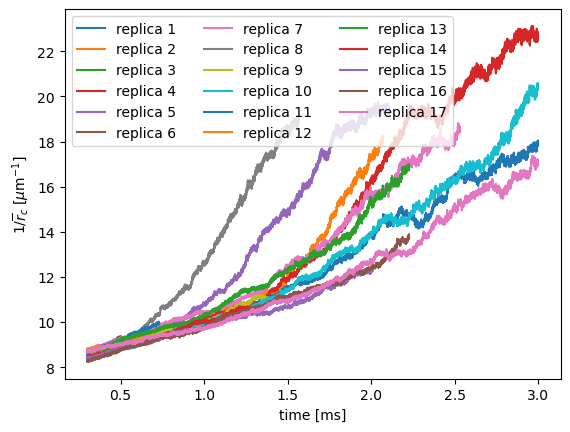

In [7]:
plt.figure()

total_time = 0.0

for i, (_t, _rc) in enumerate(zip(time_list, r_center_list)):
    
    plt.plot(_t, 1.0e3 / _rc, label=f"replica {i + 1}")
    
    total_time += _t[-1]
    
plt.xlabel("time [ms]")
plt.ylabel(inverse_rc_label)
plt.legend(ncols=3)

print(f"total simulated time = {total_time} ms")

### Setting up the bins

In [8]:
rc_min = 1.0e10
rc_max = -1.0e10

for _rc in r_center_list:
    rc_min = min(rc_min, np.amin(_rc))
    rc_max = max(rc_max, np.amax(_rc))

print(f"r_c range = {rc_min} -- {rc_max}")
global_rc_bins = np.linspace(rc_min * 1.03, rc_max * 0.97, n_div)

r_c range = 43.23749897023042 -- 121.48402973503569


### Finding trajectory weights

To securely apply the Jarzynski equation, we need to make sure that trajectories start from microstates corresponding to the canonical distribution.

The argument here is that if enough samples from the initial microstates of all trajectories are put together, they paint a better picture of the canonical ensemble. In the following cell, we use this information to fit an essentially Gaussian distribution to these samples and find how we should reweight each trajectory based on the ratio of individual samples to this distribution.

trajectory weights = [0.03935417 0.04107476 0.11400342 0.04037077 0.0388808  0.03821822
 0.03781897 0.03985666 0.0410091  0.05248355 0.11400342 0.08085849
 0.08085849 0.11400342 0.03855001 0.03930923 0.04934652]


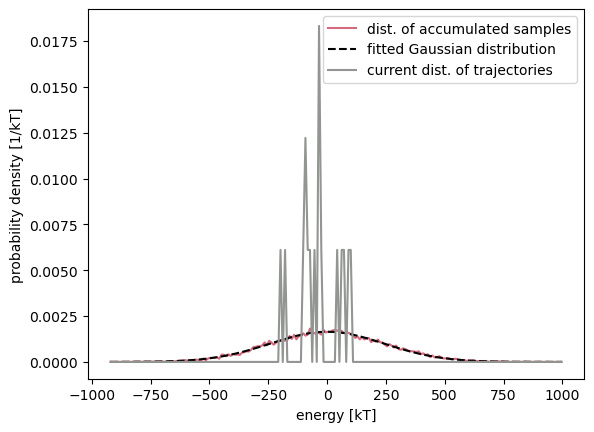

In [9]:
n_energy_bins = 200

initial_en_list = []

plt.figure()

ensemble_en = []

for _en in u_red_list:
    for __en in _en[:1000]:
        ensemble_en.append(__en)
    
ensemble_en = np.array(ensemble_en)
en_ref = ensemble_en.mean()

ensemble_en -= en_ref
ens_std = ensemble_en.std()

ens_hist, ens_bin_edges = np.histogram(ensemble_en, bins=n_energy_bins)
ens_hist = ens_hist / np.trapz(ens_hist, ens_bin_edges[:-1])

initital_en = []

for _en in u_red_list:
    initital_en.append(np.mean(_en[:10]) - en_ref)

_prob = np.exp(-0.5 * (ens_bin_edges[1:] / ens_std) ** 2) / (np.sqrt(2.0 * np.pi) * ens_std)

plt.plot(ens_bin_edges[1:], ens_hist, color=protein_color, label='dist. of accumulated samples')
plt.plot(ens_bin_edges[1:], _prob, color='black', linestyle='--', label='fitted Gaussian distribution')

init_en_hist, _ = np.histogram(initital_en, bins=ens_bin_edges)
init_en_prob = init_en_hist / np.trapz(init_en_hist, ens_bin_edges[:-1])

plt.plot(ens_bin_edges[1:], init_en_prob, color='xkcd:gray', label='current dist. of trajectories')

plt.xlabel("energy [kT]")
plt.ylabel("probability density [1/kT]")
plt.legend()

indices_of_hist = np.digitize(initital_en, ens_bin_edges[:-1], right=True) - 1

traj_weights = init_en_prob[indices_of_hist] / _prob[indices_of_hist]
traj_weights = traj_weights / np.sum(traj_weights)

print(f"trajectory weights = {traj_weights}")

### Finding $\frac{\partial \mathcal{H}_\lambda}{\partial \lambda}$

See the Methods section of the manuscript for full details.

In [10]:
def grad_H_rc(shiga_pos, box_dim, force, r_center):
    
    n_steps, n_shiga = shiga_pos.shape[0:2]
    
    log_l = np.log(box_dim[:, 0])
    
    f = r_center * log_l

    df_drc = np.zeros(n_steps)
    df_drc[1:] = (f[1:] - f[:-1]) / (r_center[1:] - r_center[:-1])
    
    drc_l_over_drc = df_drc - log_l
    
    drc_rel = 1.0 - drc_l_over_drc
    
    return -force * float(n_shiga) * drc_rel

Text(0, 0.5, '${\\partial \\mathcal{H}_\\lambda}/{\\partial \\lambda} [pN]$')

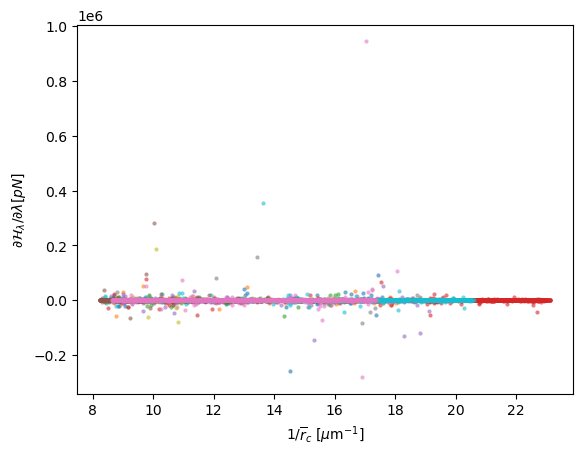

In [11]:
dH_drc_list = []

for shiga_pos, box_dim, press, r_center, potential_energy in zip(shiga_pos_list,
                                                                 box_dim_list,
                                                                 pressure_list,
                                                                 r_center_list,
                                                                 potential_energy_list):
    
    n_steps, n_shiga = shiga_pos.shape[0:2]
    
    L_X, L_Y, L_Z = box_dim[:, 0], box_dim[:, 1], box_dim[:, 2]
    A_XY = L_X * L_Y
    
    f1 = grad_H_rc(shiga_pos, box_dim, force, r_center)

    # 0.1 factor to account for Bar to MPa change, which gives the force in pN units
    dA_XY_drc = 2.0 * A_XY / r_center
    p_XY = 0.1 * 0.5 * (press[:, 0] + press[:, 1])
    
    f2 = -p_XY * L_Z * dA_XY_drc

    f = f1 + f2
    
    dH_drc_list.append(f.copy())

    plt.plot(1.0e3 / r_center, f, '.', alpha=0.6, markeredgewidth=0)

plt.xlabel(inverse_rc_label)
plt.ylabel(r'${\partial \mathcal{H}_\lambda}/{\partial \lambda} [pN]$')

### Weighting trajectories

Here, we use Monte Carlo sampling and bootstrap trajectories according to their weights.

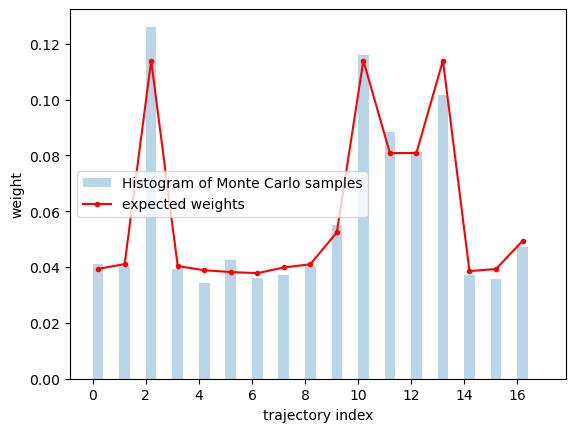

In [12]:
n_bootstrap = 71000
n_traj = len(r_center_list)

current_state = np.random.randint(0, n_traj)

state_list = []

for i in range(n_bootstrap):
    
    proposed_state = np.random.randint(0, n_traj)
    
    accept = False
    
    if traj_weights[proposed_state] > traj_weights[current_state]:
        accept = True
        
    elif traj_weights[proposed_state] / traj_weights[current_state] > np.random.random_sample():
        accept = True
        
    if accept:
        current_state = proposed_state
    
    if i > 999:
        if np.random.random_sample() > 0.95:
            state_list.append(current_state)

twbins = np.arange(n_traj + 1)

fig = plt.figure()
plt.hist(state_list, bins=twbins, alpha=0.3, density=True, width=0.4, label="Histogram of Monte Carlo samples")
plt.plot(twbins[:-1] + 0.2, traj_weights, '.r-', label="expected weights")
fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('trajectory index')
plt.ylabel('weight')
plt.legend()

### Sampling external work along each trajectory

Now we estimate the external weight along each bootstrapped trajectory sample, via integrating the corresponding $\frac{\partial \mathcal{H}_\lambda}{\partial \lambda}$ estimates along a global and constant range of reaction coordinate values. See the Methods section of the manuscript for more details.

  0%|          | 0/3457 [00:00<?, ?it/s]

Text(0, 0.5, '$\\delta W / kT$')

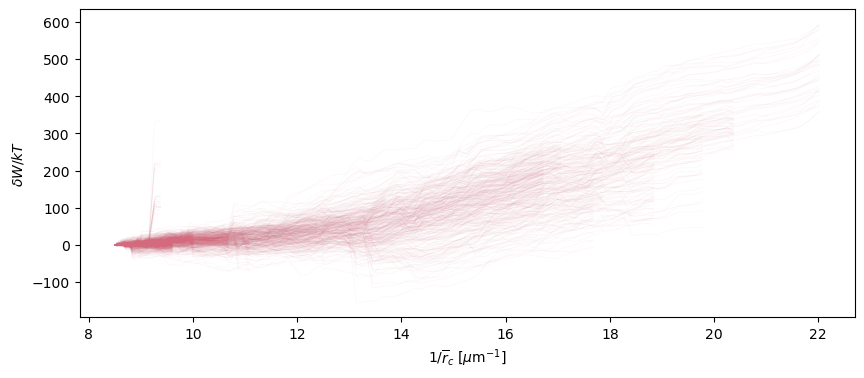

In [13]:
sampled_W = []

for i in range(n_div):
    sampled_W.append([])

bin_width = global_rc_bins[1] - global_rc_bins[0]

def sample_in_rc_interval(r_center, rc_bin_right, rc_bin_left, dH_drc):

    sel = (r_center < rc_bin_right) * (r_center >= rc_bin_left)

    sampled_dH_drc = dH_drc[sel].copy()

    if len(sampled_dH_drc) > 1:
        _mu = np.mean(sampled_dH_drc)
        _std = np.std(sampled_dH_drc)
    else:
        _mu = 0.0
        _std = 1.0
        
    return sel, sampled_dH_drc, _mu, _std
    
plt.figure(figsize=(10, 4))

for _state in tqdm(state_list):
    
    if np.random.random_sample() > 0.75:
        dH_drc, r_center = dH_drc_list[_state], r_center_list[_state]

        sampled_dH_drc_list = []
        rc_W_bin_edges = []
        
        current_left = global_rc_bins[-2]
        current_right = global_rc_bins[-1]
        
        while current_left > global_rc_bins[0]:

            sel, sampled_dH_drc, _mu, _std = sample_in_rc_interval(r_center, current_right, current_left, dH_drc)
            n_gathered_samples = np.sum(sel)
            
            valid = (np.abs(sampled_dH_drc - _mu) < 3.0 * _std)
            n_valid = np.sum(valid)

            if n_gathered_samples > 10 and n_valid / (n_gathered_samples + 1.0e-16) > 0.97:

                    sampled_dH_drc_list.append(sampled_dH_drc[valid].copy())

                    rc_W_bin_edges.append(current_left)

                    current_right = current_left

            current_left -= bin_width
        
        max_bin_index = len(sampled_dH_drc_list)

        if max_bin_index > 0:

            _y = np.zeros(max_bin_index)

            for k in range(max_bin_index):

                _y[k] = np.mean(np.random.choice(sampled_dH_drc_list[k], len(sampled_dH_drc_list[k]), replace=True))

            W = integrate.cumulative_trapezoid(y=_y, x=rc_W_bin_edges, initial=0.0)

            W_interp = np.interp(global_rc_bins, np.flip(rc_W_bin_edges), np.flip(W), left=1.0e19, right=1.0e19)

            valid = W_interp < 1.0e19
            plt.plot(1.0e3 / global_rc_bins[valid], W_interp[valid] / kT, color=protein_color, alpha=0.05, lw=0.5)

            for j in range(n_div):
                if valid[j]:
                    sampled_W[j].append(W_interp[j])
                    
plt.xlabel(r"$1 / \overline{r}_c$ [$\mu$m$^{-1}$]")
plt.ylabel(r"$\delta W / kT$")

### Application of the Jarzynski equation

In the following, decimal arithmatic is used to handle extreme quantities arising from the exponentials in the Jarzynski equation. To regain some performance, we use a thread-pool for concurrent computation.

Also, here, a second bootstrapping in invoked on samples of external work gathered for transition up to each reaction coordinate bin to estimate uncertainties in the estimated mean free energy differences.

In [14]:
dec_context = dc.Context(prec=200, rounding=dc.ROUND_HALF_EVEN)

sampled_W = np.array(sampled_W, dtype=object)

In [15]:
n_bootstrap = 1000

dG_Jar_sample = []

def calc_dG_Jar (sampled_W):
    
    dG_Jar = np.zeros(n_div)
    
    for j in range(n_div):
        
        W_accum = sampled_W[j].copy()
        
        mean_exp_W_kT = dc.Decimal(0.0, context=dec_context)
        n_samples_in_bin = len(W_accum)
       
        if n_samples_in_bin > 0:

            for _W in np.random.choice(W_accum, n_samples_in_bin, replace=True):

                mean_exp_W_kT += dc.Decimal(-_W / kT, context=dec_context).exp(context=dec_context)

            mean_exp_W_kT = mean_exp_W_kT / dc.Decimal(float(n_samples_in_bin), context=dec_context)

            dG_Jar[j] = -float(mean_exp_W_kT.ln(context=dec_context))
            
    return dG_Jar
    
pool = Pool()

calc_thread = []

for _n in range(n_bootstrap):
    calc_thread.append(pool.apply_async(calc_dG_Jar, [sampled_W.copy()]))
    
for _c in tqdm(calc_thread):
    dG_Jar_sample.append(_c.get())
    
pool.close ()

  0%|          | 0/1000 [00:00<?, ?it/s]

(-180.0, 90.0)

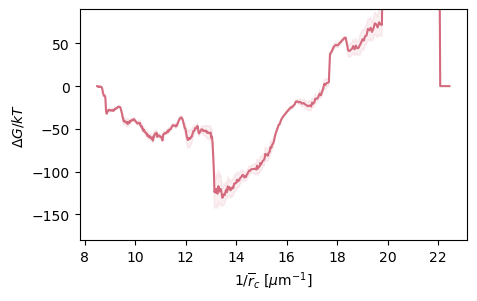

In [24]:
dG_Jar = np.mean(dG_Jar_sample, axis=0)
dG_Jar_err = np.std(dG_Jar_sample, axis=0)

plt.figure(figsize=(5, 3))
plt.plot(1.0e3 / global_rc_bins, dG_Jar, color=protein_color)
plt.fill_between(1.0e3 / global_rc_bins, dG_Jar - 0.5 * dG_Jar_err, dG_Jar + 0.5 * dG_Jar_err, color=protein_color, alpha=0.1)
plt.xlabel(inverse_rc_label)
plt.ylabel(r"$\Delta G / kT$")

plt.ylim(-180, 90)

### Saving free energy data for further analysis

In [17]:
np.savez(f"{data_folder}/Jarzynski_free_energy_{protein_name}", rc_bins=global_rc_bins, dG=dG_Jar, dG_err=dG_Jar_err)